# Task 1 : Set up colab gpu runtime environment

In [2]:
# %pip install segmentation-models-pytorch
# %pip install -U git+https://github.com/albumentations-team/albumentations
# %pip install --upgrade opencv-contrib-python

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [3]:
# !git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

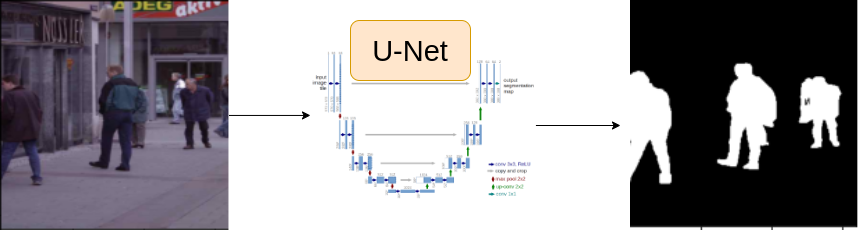

# Some Common Imports

In [4]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [5]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [6]:
CSV_FILE = 'Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '.'

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 10

ENCODER = 'timm-efficientnet-b8'
WEIGHTS = 'imagenet'


cuda


In [7]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [8]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

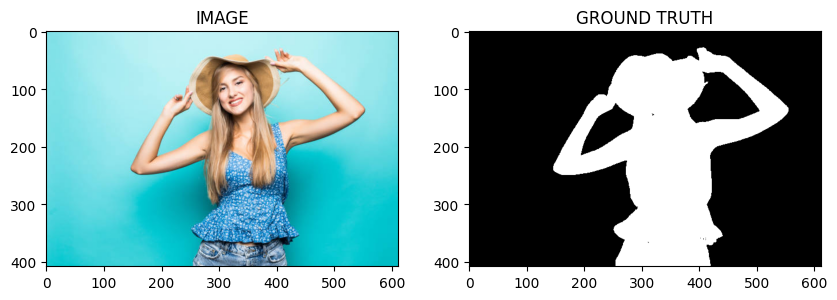

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [11]:
import albumentations as A

In [12]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ], is_check_shapes=False)

def get_valid_augs():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE)
  ], is_check_shapes=False)

# Task 4 : Create Custom Dataset 

In [13]:
from torch.utils.data import Dataset

In [14]:
class SegmentationDataset(Dataset):
  
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

    #(h, w, c) -> (c, h, w)

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask


In [15]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [16]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


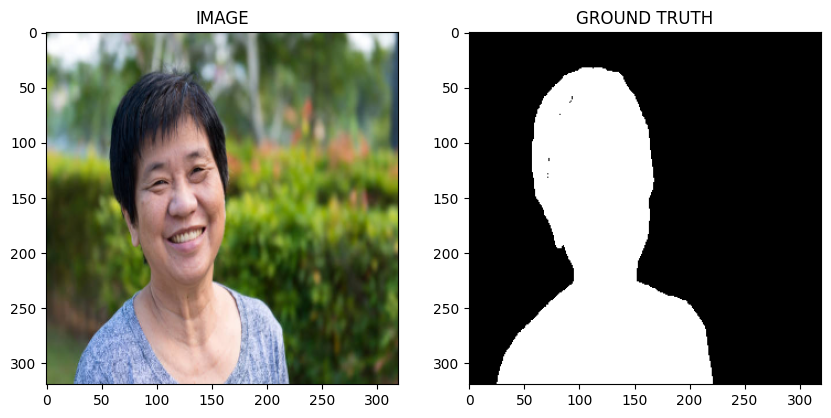

In [17]:
idx = 3

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [20]:
print(f'Total Batches in trainloader : {len(trainloader)}')
print(f'Total Batches in validloader : {len(validloader)}')

Total Batches in trainloader : 24
Total Batches in validloader : 6


In [21]:
for image, mask in trainloader:
  break

print(f'Image shape in a Batch: {image.shape}')
print(f'Mask shape in a Batch: {mask.shape}')

Image shape in a Batch: torch.Size([10, 3, 320, 320])
Mask shape in a Batch: torch.Size([10, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [22]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [37]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()
  
    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )
  
  def forward(self, images, masks = None):
    logits = self.arc(images)

    if mask != None:  
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2
    
    return logits
  

In [24]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 72, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(72, 72, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=72, bias=False)
            (bn1): BatchNormAct2d(
              72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(72, 18, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(18, 72, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
         

# Task 7 : Create Train and Validation Function 

In [25]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0
  
  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()

    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()
     
    total_loss += loss.item()

  return total_loss/len(data_loader)

In [34]:
def eval_fn(data_loader, model):
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)
      
      logits, loss = model(images, masks)
      #loss.backward()

      total_loss += loss.item()

  return total_loss/len(data_loader)

# Task 8 : Train Model

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [28]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")

    best_valid_loss = valid_loss

  print(f'Epoch: {i+1} Train Loss: {train_loss} Valid Loss:{valid_loss}')

100%|██████████| 6/6 [00:04<00:00,  1.44it/s]


SAVED MODEL
Epoch: 1 Train Loss: 0.7394610680639744 Valid Loss:10.443812688191732


100%|██████████| 6/6 [00:03<00:00,  1.53it/s]


SAVED MODEL
Epoch: 2 Train Loss: 0.4832354299724102 Valid Loss:1.503044605255127


100%|██████████| 6/6 [00:03<00:00,  1.61it/s]


SAVED MODEL
Epoch: 3 Train Loss: 0.4001680637399356 Valid Loss:0.5213800097505251


100%|██████████| 6/6 [00:03<00:00,  1.58it/s]


SAVED MODEL
Epoch: 4 Train Loss: 0.3690491219361623 Valid Loss:0.39791815479596454


100%|██████████| 6/6 [00:03<00:00,  1.56it/s]


SAVED MODEL
Epoch: 5 Train Loss: 0.28676986197630566 Valid Loss:0.323315533498923


100%|██████████| 6/6 [00:03<00:00,  1.60it/s]


SAVED MODEL
Epoch: 6 Train Loss: 0.2734957517435153 Valid Loss:0.2433985248208046


100%|██████████| 6/6 [00:03<00:00,  1.60it/s]


Epoch: 7 Train Loss: 0.27819901580611867 Valid Loss:0.3832975924015045


100%|██████████| 6/6 [00:03<00:00,  1.61it/s]


Epoch: 8 Train Loss: 0.31383276482423145 Valid Loss:0.27342625707387924


100%|██████████| 6/6 [00:03<00:00,  1.57it/s]


Epoch: 9 Train Loss: 0.2609837769220273 Valid Loss:0.2588444997866948


100%|██████████| 6/6 [00:03<00:00,  1.56it/s]


Epoch: 10 Train Loss: 0.220784199424088 Valid Loss:0.3397964934508006


100%|██████████| 6/6 [00:03<00:00,  1.57it/s]


Epoch: 11 Train Loss: 0.29150628733138245 Valid Loss:0.49894463022549945


100%|██████████| 6/6 [00:03<00:00,  1.61it/s]


Epoch: 12 Train Loss: 0.3115309743831555 Valid Loss:0.5252629468838373


100%|██████████| 6/6 [00:03<00:00,  1.63it/s]


Epoch: 13 Train Loss: 0.28686127935846645 Valid Loss:0.30676783869663876


100%|██████████| 6/6 [00:03<00:00,  1.59it/s]


Epoch: 14 Train Loss: 0.21766756878544888 Valid Loss:0.2963645781079928


100%|██████████| 6/6 [00:03<00:00,  1.57it/s]


Epoch: 15 Train Loss: 0.15694260224699974 Valid Loss:0.24636691063642502


100%|██████████| 6/6 [00:03<00:00,  1.60it/s]


Epoch: 16 Train Loss: 0.15404137906928858 Valid Loss:0.2662191490332286


100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


Epoch: 17 Train Loss: 0.17572466377168894 Valid Loss:0.26850534975528717


100%|██████████| 6/6 [00:03<00:00,  1.59it/s]


SAVED MODEL
Epoch: 18 Train Loss: 0.16849734789381424 Valid Loss:0.21199839313824972


100%|██████████| 6/6 [00:03<00:00,  1.57it/s]


Epoch: 19 Train Loss: 0.16384965802232423 Valid Loss:0.25958749403556186


100%|██████████| 6/6 [00:03<00:00,  1.61it/s]


Epoch: 20 Train Loss: 0.16521300872166952 Valid Loss:0.26400215923786163


100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


Epoch: 21 Train Loss: 0.16921301372349262 Valid Loss:0.23290183146794638


100%|██████████| 6/6 [00:03<00:00,  1.60it/s]


Epoch: 22 Train Loss: 0.1680815794194738 Valid Loss:0.2899136617779732


100%|██████████| 6/6 [00:03<00:00,  1.60it/s]


Epoch: 23 Train Loss: 0.16702776433279118 Valid Loss:0.21222426245609918


100%|██████████| 6/6 [00:03<00:00,  1.62it/s]


Epoch: 24 Train Loss: 0.16188981477171183 Valid Loss:0.2619181176026662


100%|██████████| 6/6 [00:03<00:00,  1.61it/s]

Epoch: 25 Train Loss: 0.1502480081592997 Valid Loss:0.25591424107551575


# Task 9 : Inference

In [46]:
idx = 20

model.load_state_dict(torch.load('best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0), mask.to(DEVICE).unsqueeze(0)) # (C,H,W) -> (1,C,H,W)
pred_mask = torch.sigmoid(logits_mask[0])
pred_mask = (pred_mask > 0.5)*1.0

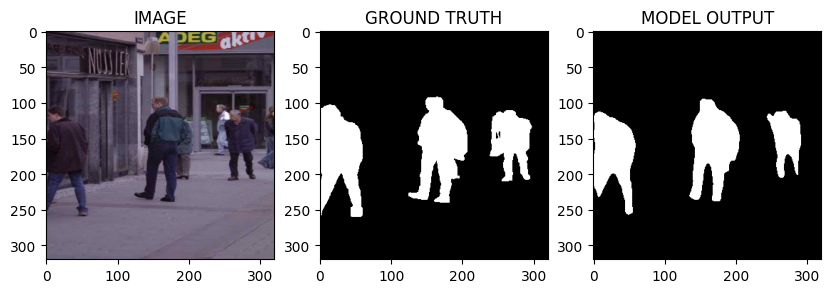

In [47]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))